Using TensorFlow backend.


process images\bear and dog.jpg
process images\bird01.jpg
process images\cats.jpg
process images\dogs.jpg
process images\dog_cat.jpg
process images\dog_cat2.jpg
process images\elephant2.jpg
process images\input.jpg
process images\one_cat.jpg
process images\one_dog.jpg
process images\two_cats.jpg
process images\two_dogs.jpg
前置處理...
預測...


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:97: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


12/12 [==============================] - 9s 733ms/step
results[0]=
0.934021532535553
save results/bear and dog.png
save results/bird01.png
save results/cats.png
save results/dogs.png
save results/dog_cat.png
save results/dog_cat2.png
save results/elephant2.png
save results/input.png
save results/one_cat.png
save results/one_dog.png
save results/two_cats.png
save results/two_dogs.png


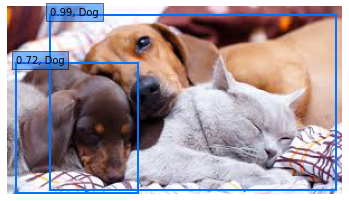

In [1]:
"""
Run object detection with VOC classes.

This is just a minor modification of code from
https://github.com/rykov8/ssd_keras
"""

from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import sys

from ssd import SSD300
from ssd_utils import BBoxUtility
import os
from os.path import basename

def create_overlay(img, results, voc_classes, plt_fname):
    plt.clf()
    # Parse the outputs.
    det_label = results[:, 0]
    det_conf = results[:, 1]
    det_xmin = results[:, 2]
    det_ymin = results[:, 3]
    det_xmax = results[:, 4]
    det_ymax = results[:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    currentAxis.axis('off')

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords,
                                            fill=False,
                                            edgecolor=color,
                                            linewidth=2))
        currentAxis.text(xmin, ymin, display_txt,
                         bbox={'facecolor': color, 'alpha': 0.5})
    plt.savefig(plt_fname)
    print("save "+plt_fname)

if __name__ == "__main__":
    import glob
    imagesList = glob.glob("images/*.jpg")

    # Load the model
    voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
                   'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
                   'Dog', 'Horse', 'Motorbike', 'Person', 'Pottedplant',
                   'Sheep', 'Sofa', 'Train', 'Tvmonitor']
    NUM_CLASSES = len(voc_classes) + 1
    input_shape = (300, 300, 3)
    model = SSD300(input_shape, num_classes=NUM_CLASSES)
    model.load_weights('weights_SSD300.hdf5', by_name=True)
   
    #存結構圖
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')

    bbox_util = BBoxUtility(NUM_CLASSES)
    
    # visualize model  
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    
    # Load the inputs
    inputs = []
    images = []
    for img_path in imagesList:
        print("process " + img_path)
        img = image.load_img(img_path, target_size=(300, 300))
        img = image.img_to_array(img)
        images.append(imread(img_path))
        inputs.append(img.copy())
    # 前置處理
    print("前置處理...")
    inputs = preprocess_input(np.array(inputs))

    # 預測
    print("預測...")
    preds = model.predict(inputs, batch_size=1, verbose=1)
    # 取得預測結果
    results = bbox_util.detection_out(preds)
    print("results[0]=")
    print(results[0][0][1])

    # create folder if not exist
    output_directory="results"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    # proces images
    for i, img in enumerate(images):
        # 產生有框的 output files
        create_overlay(img, results[i], voc_classes,
           output_directory+"/{}.png".format(basename(os.path.splitext(imagesList[i])[0])))
    # Garbage collection, to prevent from TensorFlow error
    import gc
    gc.collect()

    

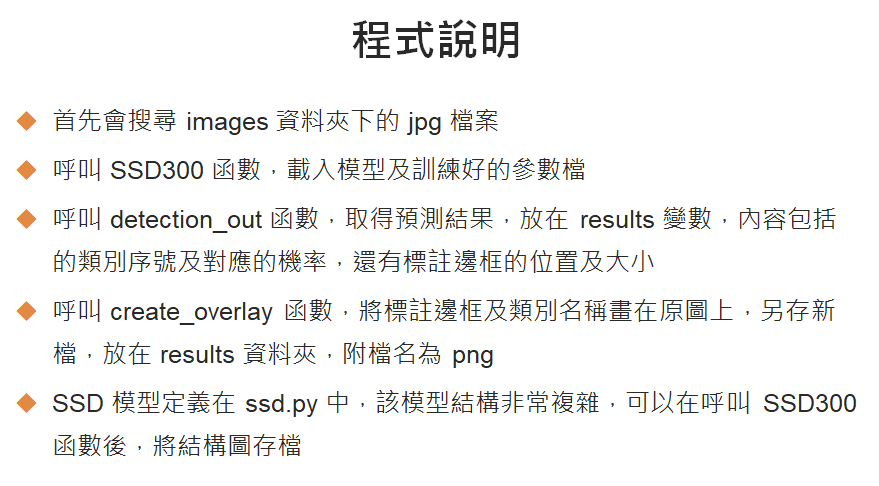

In [ ]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')